In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model


from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint

from sklearn.model_selection import train_test_split
import cv2

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.python.keras.models import Sequential
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 300
batch_size = 28

In [3]:
# train_data_path = 'train_data_uint8_512_10000_vcm_alpha.npy'
# test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
# train_label_path = 'train_label_uint8_512_10000_vcm_alpha.npy'
# test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

train_data_path = 'train_data_8000_raw.npy'
test_data_path = 'real_data_2000_raw.npy'
train_label_path = 'train_label_8000_raw.npy'
test_label_path = 'real_label_2000_raw.npy'

In [4]:
train_data = np.load(train_data_path)#[:10000, :, :, :]
test_data = np.load(test_data_path)

train_label = np.load(train_label_path)#[:10000, :]
test_label = np.load(test_label_path)

In [5]:
print(train_data.shape)
print(train_label.shape)
# test_data = test_data[1::2, :, :, :]
# test_label = test_label[1::2, :]

(8000, 512, 512, 1)
(8000, 2)


In [6]:
# train_data -= np.mean(train_data, axis = 0)
# train_data /= np.std(train_data, axis = 0)
# test_data -= np.mean(test_data, axis = 0)
# test_data /= np.std(test_data, axis = 0)

In [7]:
# def pre_normalize(im):
#     # https://www.learnopencv.com/image-quality-assessment-brisque/
#     blurred = cv2.GaussianBlur(im, (7, 7), 1.166) # apply gaussian blur to the image
#     blurred_sq = blurred * blurred
#     sigma = cv2.GaussianBlur(im * im, (7, 7), 1.166) 
#     sigma = (sigma - blurred_sq) ** 0.5
#     sigma = sigma + 1.0/255 # to make sure the denominator doesn't give DivideByZero Exception
#     structdis = (im - blurred)/sigma # final MSCN(i, j) image
#     t = im - blurred
#     t = (t-t.min())/(t.max() - t.min())
#     return t

# for iii in range(train_data.shape[0]):
#     train_data[iii, :, :, 0] = pre_normalize(train_data[iii, :, :, 0].astype(np.float32))

In [8]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# for idx in range(10):
#     plt.imshow(train_data[idx, :, :, 0].astype(np.float32))
#     plt.show()
#     print(train_label[idx, :])
# #print(train_data.dtype)
# # batch_features = np.zeros((image_size//2, image_size//2, 4))
# # batch_features[:, :, 0] = train_data[idx, 1::2, ::2, 0]
# # batch_features[:, :, 1] = train_data[idx, ::2, ::2, 0]
# # batch_features[:, :, 2] = train_data[idx, 1::2, 1::2, 0]
# # batch_features[:, :, 3] = train_data[idx, ::2, 1::2, 0]
# # plt.imshow(batch_features[:, :, 3]*16383)

#     plt.imshow(test_data[idx, :, :, 0].astype(np.float32))
#     plt.show()
#     print(test_label[idx, :])

In [9]:
# In[7]:
input_image1 = Input(shape=(512, 512, 1), name = "input")

layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=relu, name="Conv1_1")(input_image1)
#layer1_1 = LeakyReLU(0.1)(layer1_1)

layer2_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv2_1")(layer1_1)
#layer2_1 = LeakyReLU(0.1)(layer2_1)

layer3_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu, name="Conv3_1")(layer2_1)

flattened = Flatten(name="flat")(layer3_1)
dense1 = Dense(1024, name="d1")(flattened)
ReLU1 = LeakyReLU(0.1, name="lr1")(dense1)
dp1 = Dropout(0.5)(ReLU1)

dense2 = Dense(256, name="d2")(dp1)
ReLU2 = LeakyReLU(0.1, name="lr2")(dense2)
dp2 = Dropout(0.5)(ReLU2)

dense3 = Dense(64, name="d3")(dp2)
ReLU3 = LeakyReLU(0.1, name="lr3")(dense3)
dp3 = Dropout(0.5)(ReLU3)

output_position = Dense(1, name="out")(dp3)
print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="raw_models/gen/n_{epoch:03d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("out/BiasAdd:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 4)         260       
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 16, 16, 8)         520       
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 4, 4, 8)           1032      
_________________________________________________________________
flat (Flatten)               (None, 128)               0         
__________________________________

In [10]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            ################!!!
#             batch_features = np.zeros((batch_size, image_size//2, image_size//2, 4))
#             batch_features[:, :, :, 0] = features[i:i+batch_size, 1::2, ::2, 0]
#             batch_features[:, :, :, 1] = features[i:i+batch_size, ::2, ::2, 0]
#             batch_features[:, :, :, 2] = features[i:i+batch_size, 1::2, 1::2, 0]
#             batch_features[:, :, :, 3] = features[i:i+batch_size, ::2, 1::2, 0]
            batch_features = np.zeros((batch_size, image_size, image_size, 1))
            batch_features = features[i:i+batch_size, :, :, :]
            batch_features = batch_features.astype('float16')#/255###########################
            batch_labels = abs(labels[i:i+batch_size, 1:2] - labels[i:i+batch_size, :1])*100
            yield (batch_features, batch_labels)

In [11]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer=opt)

Instructions for updating:
Use tf.cast instead.


In [12]:
# X_train, X_test, y_train, y_test = train_test_split(
#     train_data, train_label, test_size=0.01, random_state=2233)

In [13]:
# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, abs(train_label[:,1:2]-train_label[:,0:1])/100, 
#           epochs = 100,batch_size = batch_size, #validation_split=0.2,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, abs(test_label[:,1:2]-test_label[:,0:1])/100), 
#           verbose=1, callbacks = [tcbc, checkpoint])
history = model.fit_generator(data_gen(train_data, train_label, batch_size), 
                    steps_per_epoch = train_data.shape[0]//batch_size, epochs = epochs,
                    validation_data=data_gen(test_data, test_label, batch_size), 
                    validation_steps = batch_size,verbose=1, callbacks = [tcbc, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
28/28 [==============================] - 1s 23ms/step - loss: 4.8352

Epoch 00001: val_loss improved from inf to 4.83523, saving model to raw_models/gen/n_001-4.835.hdf5
285/285 [==============================] - 8s 29ms/step - loss: 4.8975 - val_loss: 4.8352
Epoch 2/300
28/28 [==============================] - 1s 20ms/step - loss: 4.2131

Epoch 00002: val_loss improved from 4.83523 to 4.21314, saving model to raw_models/gen/n_002-4.213.hdf5
285/285 [==============================] - 7s 26ms/step - loss: 2.3962 - val_loss: 4.2131
Epoch 3/300
28/28 [==============================] - 1s 21ms/step - loss: 4.6944

Epoch 00003: val_loss did not improve from 4.21314
285/285 [==============================] - 7s 25ms/step - loss: 2.0992 - val_loss: 4.6944
Epoch 4/300
28/28 [==============================] - 1s 21ms/step - loss: 3.4596

Epoch 00004: val_loss improved from 4.21314 to 3.45961, saving model to raw_models/gen/n_004-3.460.

285/285 [==============================] - 7s 26ms/step - loss: 1.0173 - val_loss: 1.4730
Epoch 34/300
28/28 [==============================] - 1s 21ms/step - loss: 1.7124

Epoch 00034: val_loss did not improve from 1.47305
285/285 [==============================] - 7s 24ms/step - loss: 1.0353 - val_loss: 1.7124
Epoch 35/300
28/28 [==============================] - 1s 20ms/step - loss: 1.7679

Epoch 00035: val_loss did not improve from 1.47305
285/285 [==============================] - 7s 25ms/step - loss: 0.9967 - val_loss: 1.7679
Epoch 36/300
28/28 [==============================] - 1s 21ms/step - loss: 1.3237

Epoch 00036: val_loss improved from 1.47305 to 1.32374, saving model to raw_models/gen/n_036-1.324.hdf5
285/285 [==============================] - 7s 25ms/step - loss: 0.9760 - val_loss: 1.3237
Epoch 37/300
28/28 [==============================] - 1s 21ms/step - loss: 1.5180

Epoch 00037: val_loss did not improve from 1.32374
285/285 [==============================] - 7s 25ms/

Epoch 70/300
28/28 [==============================] - 1s 21ms/step - loss: 1.3706

Epoch 00070: val_loss did not improve from 1.02381
285/285 [==============================] - 7s 25ms/step - loss: 0.7280 - val_loss: 1.3706
Epoch 71/300
28/28 [==============================] - 1s 21ms/step - loss: 1.4750

Epoch 00071: val_loss did not improve from 1.02381
285/285 [==============================] - 7s 24ms/step - loss: 0.7164 - val_loss: 1.4750
Epoch 72/300
28/28 [==============================] - 1s 21ms/step - loss: 1.7277

Epoch 00072: val_loss did not improve from 1.02381
285/285 [==============================] - 7s 25ms/step - loss: 0.7307 - val_loss: 1.7277
Epoch 73/300
28/28 [==============================] - 1s 22ms/step - loss: 1.7120

Epoch 00073: val_loss did not improve from 1.02381
285/285 [==============================] - 7s 25ms/step - loss: 0.7326 - val_loss: 1.7120
Epoch 74/300
28/28 [==============================] - 1s 22ms/step - loss: 1.5358

Epoch 00074: val_loss

Epoch 142/300
28/28 [==============================] - 1s 21ms/step - loss: 0.9454

Epoch 00142: val_loss did not improve from 0.93493
285/285 [==============================] - 7s 25ms/step - loss: 0.5175 - val_loss: 0.9454
Epoch 143/300
28/28 [==============================] - 1s 20ms/step - loss: 1.0848

Epoch 00143: val_loss did not improve from 0.93493
285/285 [==============================] - 7s 25ms/step - loss: 0.5255 - val_loss: 1.0848
Epoch 144/300
28/28 [==============================] - 1s 22ms/step - loss: 1.2158

Epoch 00144: val_loss did not improve from 0.93493
285/285 [==============================] - 7s 25ms/step - loss: 0.5169 - val_loss: 1.2158
Epoch 145/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1939

Epoch 00145: val_loss did not improve from 0.93493
285/285 [==============================] - 7s 25ms/step - loss: 0.5405 - val_loss: 1.1939
Epoch 146/300
28/28 [==============================] - 1s 20ms/step - loss: 1.1598

Epoch 00146: val

Epoch 215/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2766

Epoch 00215: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.4238 - val_loss: 1.2766
Epoch 216/300
28/28 [==============================] - 1s 22ms/step - loss: 1.1371

Epoch 00216: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.4144 - val_loss: 1.1371
Epoch 217/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2272

Epoch 00217: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 24ms/step - loss: 0.4157 - val_loss: 1.2272
Epoch 218/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1195

Epoch 00218: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.4229 - val_loss: 1.1195
Epoch 219/300
28/28 [==============================] - 1s 21ms/step - loss: 1.0751

Epoch 00219: val

Epoch 252/300
28/28 [==============================] - 1s 20ms/step - loss: 0.9634

Epoch 00252: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.3995 - val_loss: 0.9634
Epoch 253/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2576

Epoch 00253: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 24ms/step - loss: 0.3973 - val_loss: 1.2576
Epoch 254/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2356

Epoch 00254: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 24ms/step - loss: 0.3966 - val_loss: 1.2356
Epoch 255/300
28/28 [==============================] - 1s 22ms/step - loss: 1.3136

Epoch 00255: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.4014 - val_loss: 1.3136
Epoch 256/300
28/28 [==============================] - 1s 21ms/step - loss: 1.0624

Epoch 00256: val

Epoch 289/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1261

Epoch 00289: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.3661 - val_loss: 1.1261
Epoch 290/300
28/28 [==============================] - 1s 21ms/step - loss: 1.1708

Epoch 00290: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.3725 - val_loss: 1.1708
Epoch 291/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2066

Epoch 00291: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.3668 - val_loss: 1.2066
Epoch 292/300
28/28 [==============================] - 1s 20ms/step - loss: 1.0872

Epoch 00292: val_loss did not improve from 0.90222
285/285 [==============================] - 7s 25ms/step - loss: 0.3725 - val_loss: 1.0872
Epoch 293/300
28/28 [==============================] - 1s 21ms/step - loss: 1.2369

Epoch 00293: val

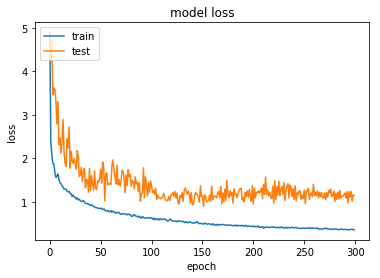

In [14]:
import pickle
with open('auto_hist_raw', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# with open(r"raw_models/trainHistoryDict_raw", "rb") as input_file:
#     history = pickle.load(input_file)
import matplotlib.pyplot as plt
%matplotlib inline
# plt.plot(history['acc'])
# plt.plot(history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.scatter([88], history['val_loss'][88], marker='*', c = 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# model.save('my_model_512.h5')

In [16]:
# print(train_label[:, :10])

In [6]:
from tensorflow.python.keras.models import load_model
model = load_model('raw_models/gen/n_152-0.902.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


[1.    1.078 0.   ]


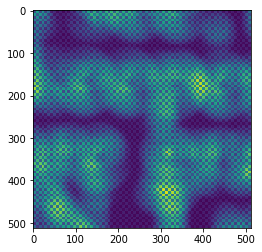

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
idxx = 93
plt.imshow(test_data[idxx, :, :, 0].astype(np.float32))
print(test_label[idxx, :])

In [27]:
model.predict(test_data[idxx:idxx+1, :, :, :1])/100

array([[0.07027449]], dtype=float32)

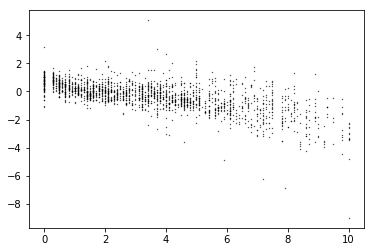

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
batch_features_ = np.ones(test_label.shape)
for i in range(2000//64-1): #
    batch_features = test_data[64*i:64*i+64,:,:,:]
#    batch_features = np.zeros((64, image_size//2, image_size//2, 4))
#     batch_features[:, :, :, 0] = X_test[64*i:64*i+64, 1::2, ::2, 0]
#     batch_features[:, :, :, 1] = X_test[64*i:64*i+64, ::2, ::2, 0]
#     batch_features[:, :, :, 2] = X_test[64*i:64*i+64, 1::2, 1::2, 0]
#     batch_features[:, :, :, 3] = X_test[64*i:64*i+64, ::2, 1::2, 0]
    batch_features_[64*i:64*i+64, :] = model.predict(batch_features)

plt.scatter(abs(test_label[:1936, 0] - test_label[:1936, 1])*100, batch_features_[:1936, 0] - abs(test_label[:1936, 0] - test_label[:1936, 1])*100, color='black', s = 0.1)
plt.show()

In [21]:
# for i in range(6000//64-1): #
#     train_pred[64*i:64*i+64, :, :, :] = model.predict(X_train[64*i:64*i+64, :, :, :1])
#     plt.scatter(abs(y_train[64*i:64*i+64, 0] - y_train[64*i:64*i+64, 1])*100, train_pred[:, 0] - abs(y_train[64*i:64*i+64, 0] - y_train[64*i:64*i+64, 1])*100, color='black', s = 0.1)
# plt.show()

In [22]:
# test_pred[test_pred<0]= 0
# print(test_pred[:, 0])

In [23]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.imshow(test_data[0, :, :, 0])
# print(test_label)

In [24]:
# plt.scatter(abs(test_label[:, 0] - test_label[:, 1]), test_pred[:, 0])